In [443]:
!pip install yfinance

https://pypi.org/project/yfinance/ 

In [444]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [445]:
# def upload_prices_COTdates()


# def make_futureprice_matrix()

In [446]:
# Файл с датировкой отчетов СОТ
dates_url = 'https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/Даты%20отчетов%20СОТ.txt'
dates = pd.read_csv('https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/COTR_Dates.txt', parse_dates=True)

In [447]:
dates['Date'] = pd.to_datetime(dates['Date'])
# dates['fDate'] = dates['Date']

In [448]:
# Commodities
Wheat_SRW = yf.Ticker('ZW=F').history(period="max")
Wheat_SRW.index.name = 'Index'
Wheat_SRW['Date'] = Wheat_SRW.index
XXX = Wheat_SRW.append(dates)
Wheat_SRW = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(dates['Date'], how='right')

Soybeans = yf.Ticker('ZS=F').history(period="max")
Soybeans.index.name = 'Index'

In [449]:
# Financial
Canadian_Dollar = yf.Ticker('6C=F').history(period="max")
Canadian_Dollar.index.name = 'Index'
Canadian_Dollar['Date'] = Canadian_Dollar.index
XXX = Canadian_Dollar.append(dates)
Canadian_Dollar = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(dates['Date'], how='right')

British_Pound = yf.Ticker('6B=F').history(period="max")
British_Pound.index.name = 'Index'
British_Pound['Date'] = British_Pound.index

In [450]:
column_week_prefix = "Week_"
column_bilweek_prefix = "Bin_Long_Week_"
column_bisweek_prefix = "Bin_Short_Week_"
column_binweek_prefix = "Bin_Neut_Week_"
number_future_weeks = 26

target_price_count = 0.12
skip_count_less = 5

Wheat_SRW.drop('Dividends', axis=1, inplace=True)
Wheat_SRW.drop('Stock Splits', axis=1, inplace=True)

In [451]:
for i in range(number_future_weeks):
    Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))] = ((Wheat_SRW['Close'].shift(-i-1)) / Wheat_SRW['Close'] - 1)

    Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] = Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))]
    Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))] = Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))]
    Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] = Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))]

    Wheat_SRW.loc[Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] >= target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 1
    Wheat_SRW.loc[Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] < target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 0

    Wheat_SRW.loc[Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))] <= -target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 1
    Wheat_SRW.loc[Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))] > -target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 0

    Wheat_SRW.loc[((Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] > -target_price_count) & (Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] < target_price_count)), str(column_binweek_prefix + '%03d' % (i+1))] = 1
    Wheat_SRW.loc[(Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] <= -target_price_count) & (Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] >= target_price_count), str(column_binweek_prefix + '%03d' % (i+1))] = 0

# Нужно исправить нейтраль, ставит десятичные доли

In [452]:
matrix_long = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, : number_future_weeks]
matrix_neutral = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, number_future_weeks : number_future_weeks*2]
matrix_short = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, number_future_weeks*2 : number_future_weeks*3]
matrix_real = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, number_future_weeks*3 : number_future_weeks*4]

Wheat_SRW['Long'] = matrix_long.sum(axis=1)
Wheat_SRW['Short'] = matrix_short.sum(axis=1)
Wheat_SRW['Neutral'] = matrix_neutral.sum(axis=1)

In [453]:
Wheat_SRW['Net'] = Wheat_SRW['Long'] - Wheat_SRW['Short']

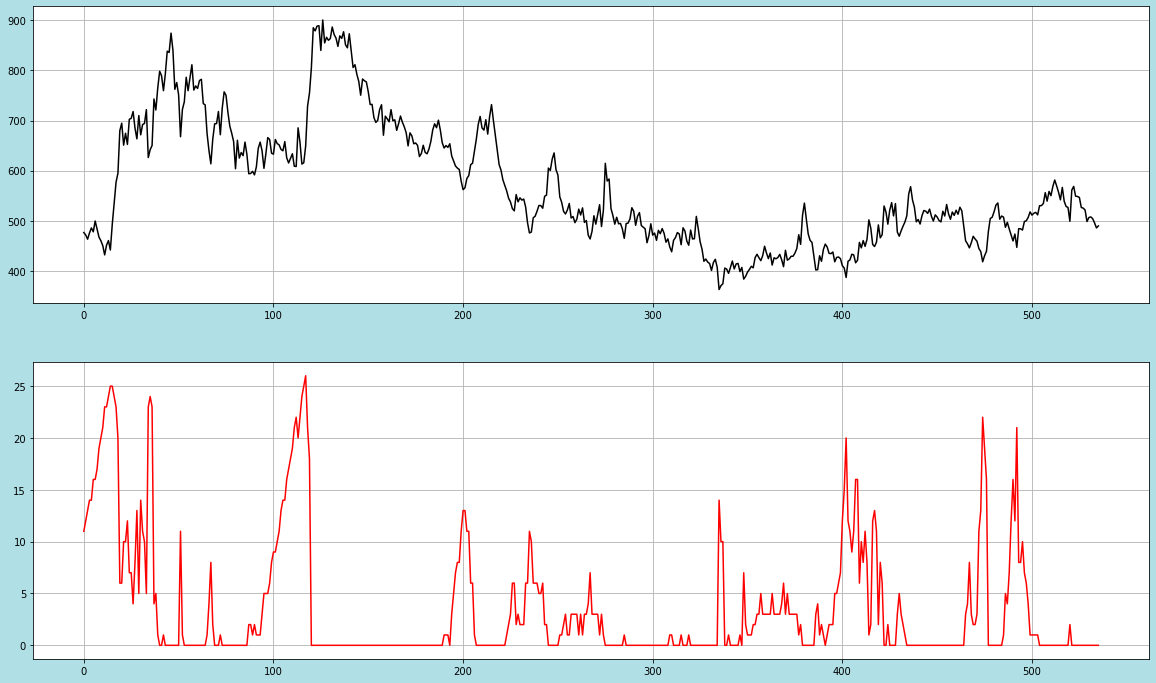

In [467]:
fig = plt.figure()
ax_1 = fig.add_subplot(2, 1, 1)
ax_1.grid()
ax_2 = fig.add_subplot(2, 1, 2)
ax_2.grid()
fig.set(facecolor = 'powderblue')

ax_1.plot(Wheat_SRW['Close'], color='black')
ax_2.plot(Wheat_SRW['Net'], color='red')

fig.set_figwidth(20)
fig.set_figheight(12)
fig.show()